# Load Data

## Load Peeringdb

In [3]:
import json
from pathlib import Path
import pandas as pd

filepath = Path('../../preprocessing/data/peeringdb/peeringdb_2_dump_2025_10_21.json')

with filepath.open('r', encoding='utf-8') as f:
    dump = json.load(f)

# extract the net.data section and load into a DataFrame
net_data = dump.get('net', {}).get('data')
if net_data is None:
    raise KeyError("JSON does not contain 'net' -> 'data' structure")

net_df = pd.DataFrame(net_data)
net_df['asn'] = net_df['asn'].astype(int)
net_df = net_df[net_df['info_type'] != '']

# show a quick preview
net_df.head()

,id,org_id,name,aka,name_long,website,social_media,asn,looking_glass,route_server,...,policy_ratio,policy_contracts,allow_ixp_update,status_dashboard,rir_status,rir_status_updated,logo,created,updated,status
0,1,8897,GTT Communications (AS4436),Formerly known as nLayer Communications,,http://www.gtt.net,"[{'service': 'website', 'identifier': 'http://...",4436,,,...,True,Required,False,None,ok,2024-06-26T04:47:55Z,None,2004-07-28T00:00:00Z,2022-07-27T05:33:22Z,ok
1,2,14,Akamai Technologies,,,https://www.akamai.com/,"[{'service': 'website', 'identifier': 'https:/...",20940,,,...,False,Not Required,False,https://www.akamaistatus.com/,ok,2024-06-26T04:47:55Z,None,2004-07-28T00:00:00Z,2025-10-20T12:16:12Z,ok
2,3,17,DALnet IRC Network,,,http://www.dal.net,"[{'service': 'website', 'identifier': 'http://...",31800,,,...,False,Not Required,False,,ok,2024-06-26T04:47:55Z,None,2004-07-28T00:00:00Z,2025-01-09T13:42:07Z,ok
3,5,9350,Swisscom,IP-Plus,,http://www.swisscom.com,"[{'service': 'website', 'identifier': 'http://...",3303,,telnet://route-server.ip-plus.net,...,True,Required,False,,ok,2024-06-26T04:47:55Z,None,2004-07-28T00:00:00Z,2025-08-12T06:33:30Z,ok
4,6,23,Cox Communications,Cox Communications,,http://www.cox.com/peering,"[{'service': 'website', 'identifier': 'http://...",22773,,,...,False,Required,False,,ok,2024-06-26T04:47:55Z,None,2004-07-28T00:00:00Z,2022-11-28T22:55:17Z,ok


## Load data from Clickhouse

In [4]:
import clickhouse_connect

client = clickhouse_connect.get_client(
    host='localhost', port=8123,
    username='default', password=''
)

query = """
/* Gewichtetes Zentrum und umfangreiche Distanz-Statistiken (Kilometer) */
WITH base AS (
    SELECT
        asn,
        latitude,
        longitude,
        country,
        toUInt64(ip_end - ip_start + 1) AS w
    FROM ip_location_asn
    WHERE ip_version = 4
      AND origin = 'ipinfo'
),
vec AS (
    SELECT
        asn,
        sum(w * cos(radians(latitude)) * cos(radians(longitude))) AS X,
        sum(w * cos(radians(latitude)) * sin(radians(longitude))) AS Y,
        sum(w * sin(radians(latitude)))                           AS Z,
        sum(w)                                                    AS W
    FROM base
    GROUP BY asn
),
center AS (
    SELECT
        asn,
        degrees(atan2(Y, X))                       AS center_lon,
        degrees(atan2(Z, sqrt(X * X + Y * Y)))     AS center_lat
    FROM vec
),
joined AS (
    SELECT
        b.asn,
        b.w,
        b.country,
        c.center_lat,
        c.center_lon,
        greatCircleDistance(b.longitude, b.latitude, c.center_lon, c.center_lat) / 1000 AS d_km
    FROM base AS b
    INNER JOIN center AS c USING (asn)
),
stats AS (
    SELECT
        asn,
        any(center_lat) AS center_lat,
        any(center_lon) AS center_lon,
        sum(w)  AS total_weight,
        avgWeighted(d_km,       w) AS mean_km,
        avgWeighted(d_km * d_km, w) AS mean_sq_km2,
        quantileExactWeighted(0.25)(d_km, w) AS p25_km,
        quantileExactWeighted(0.50)(d_km, w) AS p50_km,
        quantileExactWeighted(0.75)(d_km, w) AS p75_km,
        quantileExactWeighted(0.90)(d_km, w) AS p90_km,
        quantileExactWeighted(0.95)(d_km, w) AS p95_km,
        quantileExactWeighted(0.99)(d_km, w) AS p99_km,
        min(d_km) AS min_km,
        max(d_km) AS max_km,
        sumIf(w, d_km <=  100) / sum(w) AS share_le_100km,
        sumIf(w, d_km <=  500) / sum(w) AS share_le_500km,
        sumIf(w, d_km <= 1000) / sum(w) AS share_le_1000km
    FROM joined
    GROUP BY asn
),
geo_meta AS (
    SELECT
        asn,
        uniqExact((latitude, longitude)) AS unique_points,
        uniqExact(country)               AS country_count
    FROM base
    GROUP BY asn
)
SELECT
    s.asn,
    round(s.center_lat, 5) AS center_lat,
    round(s.center_lon, 5) AS center_lon,
    s.total_weight,
    gm.unique_points,
    gm.country_count,
    round(s.mean_km, 2)                         AS mean_km,
    round(greatest(s.mean_sq_km2 - s.mean_km * s.mean_km, 0), 2) AS var_km2,
    round(sqrt(greatest(s.mean_sq_km2 - s.mean_km * s.mean_km, 0)), 2) AS std_km,
    round(s.p75_km - s.p25_km, 2)               AS iqr_km,
    round(s.p25_km, 2)                          AS p25_km,
    round(s.p50_km, 2)                          AS p50_km,
    round(s.p75_km, 2)                          AS p75_km,
    round(s.p90_km, 2)                          AS p90_km,
    round(s.p95_km, 2)                          AS p95_km,
    round(s.p99_km, 2)                          AS p99_km,
    round(s.min_km, 2)                          AS min_km,
    round(s.max_km, 2)                          AS max_km,
    round(s.share_le_100km * 100, 2)            AS pct_ips_le_100km,
    round(s.share_le_500km * 100, 2)            AS pct_ips_le_500km,
    round(s.share_le_1000km * 100, 2)           AS pct_ips_le_1000km
FROM stats AS s
LEFT JOIN geo_meta AS gm USING (asn)
ORDER BY asn
"""

ch_df = client.query_df(query)
ch_df.head()


,asn,center_lat,center_lon,total_weight,unique_points,country_count,mean_km,var_km2,std_km,iqr_km,...,p50_km,p75_km,p90_km,p95_km,p99_km,min_km,max_km,pct_ips_le_100km,pct_ips_le_500km,pct_ips_le_1000km
0,1,25.96800,92.57890,78170880,79,61,244.02,81524.56,285.53,85.42,...,202.41,269.52,270.88,323.86,2174.95,22.74,16533.53,14.53,96.74,97.75
1,2,33.23043,-61.91418,86016,4,4,3182.86,10932427.46,3306.42,0.00,...,1427.96,1427.96,8556.52,11221.18,11221.18,1427.96,11221.18,0.00,0.00,0.00
2,3,42.49447,-76.06584,46607360,21,16,702.31,781753.99,884.17,0.00,...,411.17,411.17,1267.02,3902.24,3906.49,227.04,15164.77,0.00,85.21,85.21
3,4,39.84525,-77.49818,162816,7,6,435.78,3240972.63,1800.27,0.42,...,112.86,112.86,112.86,112.86,12790.22,81.32,12790.22,17.61,95.60,95.60
4,5,36.12522,-113.40178,2304,4,4,1766.67,7530375.89,2744.15,0.33,...,801.17,801.17,9527.87,9527.87,9527.87,768.83,9527.87,0.00,0.00,88.89


## Join the dataframes

In [5]:
joined = net_df.merge(ch_df, on='asn', how='left')
joined.fillna(0, inplace=True)
joined.head()


,id,org_id,name,aka,name_long,website,social_media,asn,looking_glass,route_server,...,p50_km,p75_km,p90_km,p95_km,p99_km,min_km,max_km,pct_ips_le_100km,pct_ips_le_500km,pct_ips_le_1000km
0,1,8897,GTT Communications (AS4436),Formerly known as nLayer Communications,,http://www.gtt.net,"[{'service': 'website', 'identifier': 'http://...",4436,,,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,2,14,Akamai Technologies,,,https://www.akamai.com/,"[{'service': 'website', 'identifier': 'https:/...",20940,,,...,662.51,900.34,3440.84,3440.84,6319.63,9.45,18126.77,0.13,46.99,78.79
2,3,17,DALnet IRC Network,,,http://www.dal.net,"[{'service': 'website', 'identifier': 'http://...",31800,,,...,2079.78,5511.55,5511.55,5511.55,5511.55,2073.76,5511.55,0.00,0.00,0.00
3,5,9350,Swisscom,IP-Plus,,http://www.swisscom.com,"[{'service': 'website', 'identifier': 'http://...",3303,,telnet://route-server.ip-plus.net,...,59.96,108.85,124.59,161.25,167.13,3.90,6641.84,72.07,100.00,100.00
4,6,23,Cox Communications,Cox Communications,,http://www.cox.com/peering,"[{'service': 'website', 'identifier': 'http://...",22773,,,...,873.86,1742.90,1960.31,2242.55,2401.69,19.55,14417.21,0.72,13.60,51.42


# Get Stats as Plots

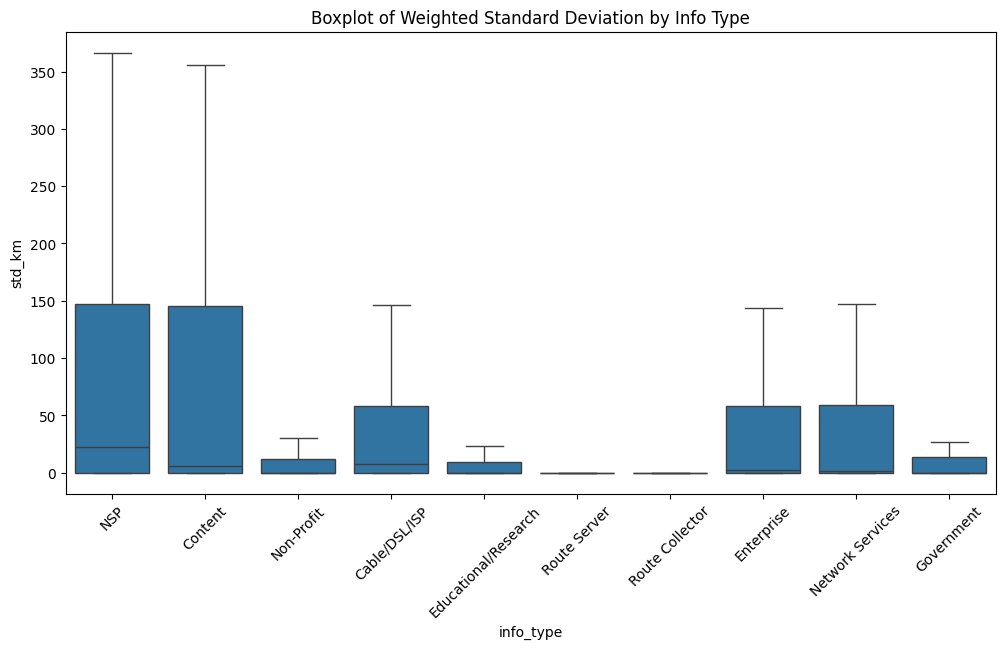

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter out rows where std_m_weighted is NaN for cleaner plot
filtered_joined = joined.dropna(subset=['std_km'])

# Create boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(data=filtered_joined, x='info_type', y='std_km', showfliers=False)
plt.xticks(rotation=45)
plt.title('Boxplot of Weighted Standard Deviation by Info Type')
plt.show()

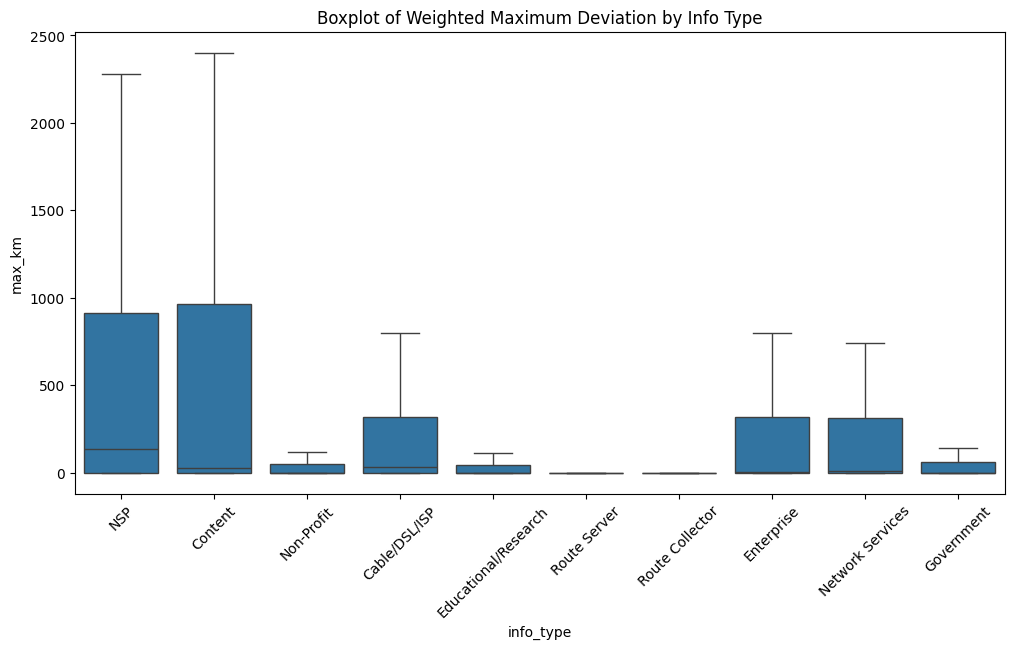

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter out rows where max_m is NaN for cleaner plot
filtered_joined = joined.dropna(subset=['max_km'])

# Create boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(data=filtered_joined, x='info_type', y='max_km', showfliers=False)
plt.xticks(rotation=45)
plt.title('Boxplot of Weighted Maximum Deviation by Info Type')
plt.show()

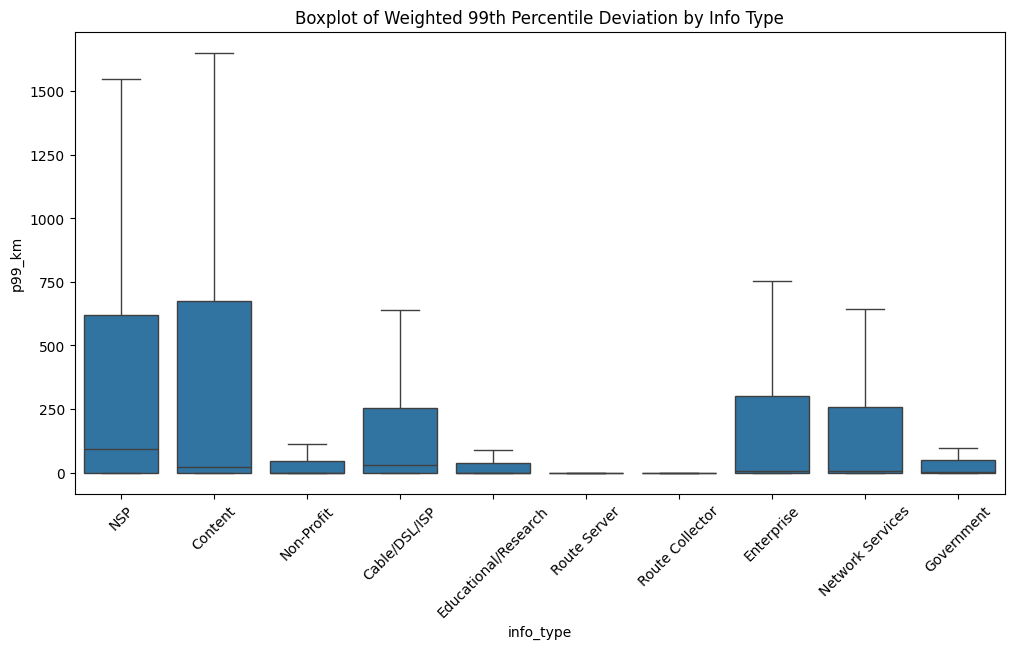

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter out rows where max_m is NaN for cleaner plot
filtered_joined = joined.dropna(subset=['p99_km'])

# Create boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(data=filtered_joined, x='info_type', y='p99_km', showfliers=False)
plt.xticks(rotation=45)
plt.title('Boxplot of Weighted 99th Percentile Deviation by Info Type')
plt.show()

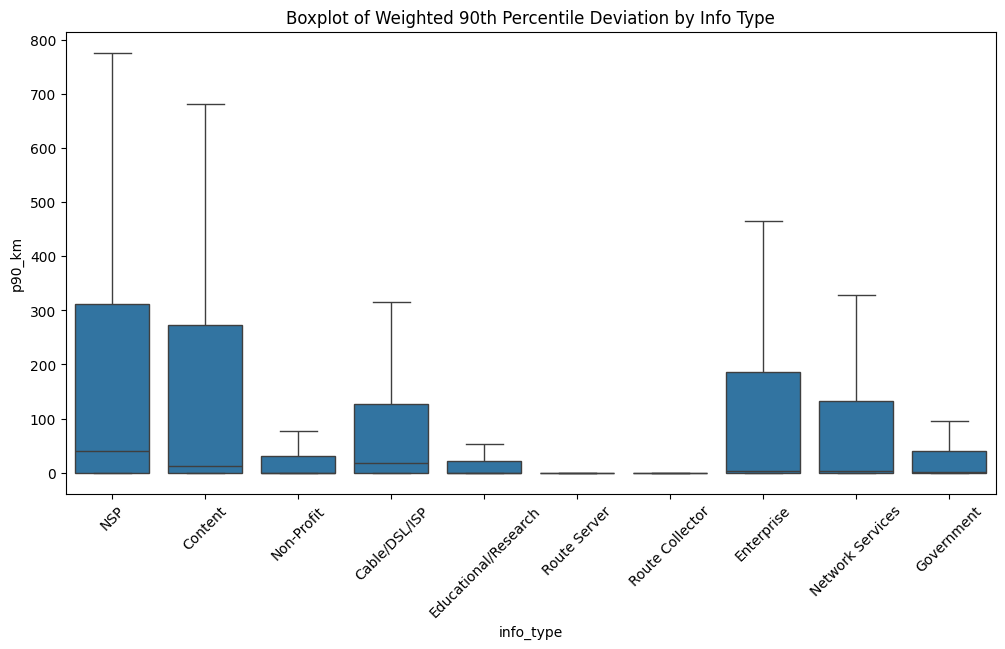

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter out rows where max_m is NaN for cleaner plot
filtered_joined = joined.dropna(subset=['p90_km'])

# Create boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(data=filtered_joined, x='info_type', y='p90_km', showfliers=False)
plt.xticks(rotation=45)
plt.title('Boxplot of Weighted 90th Percentile Deviation by Info Type')
plt.show()

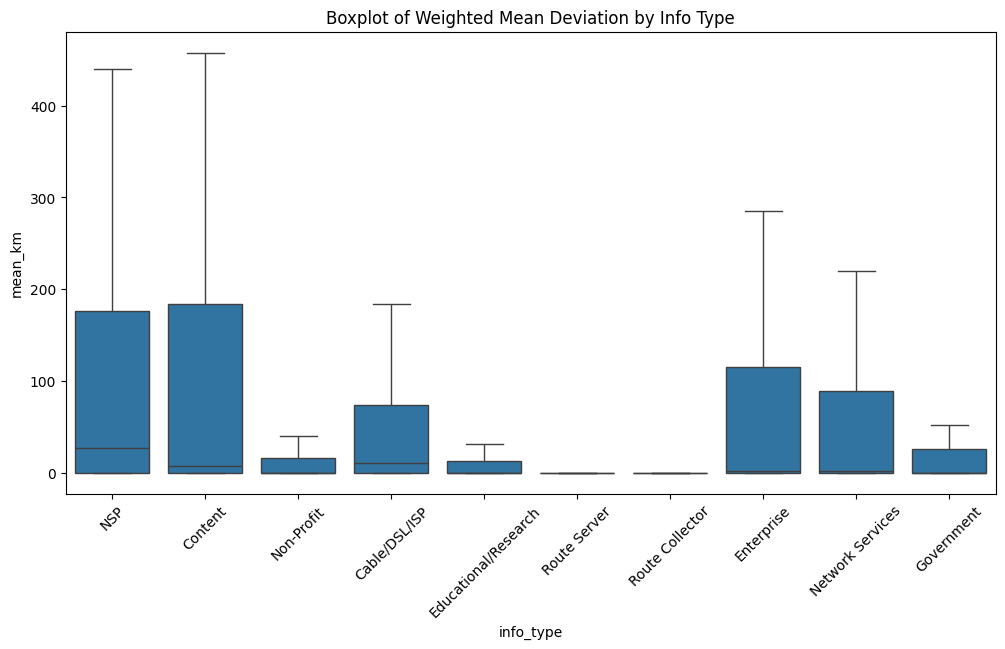

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter out rows where max_m is NaN for cleaner plot
filtered_joined = joined.dropna(subset=['mean_km'])

# Create boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(data=filtered_joined, x='info_type', y='mean_km', showfliers=False)
plt.xticks(rotation=45)
plt.title('Boxplot of Weighted Mean Deviation by Info Type')
plt.show()

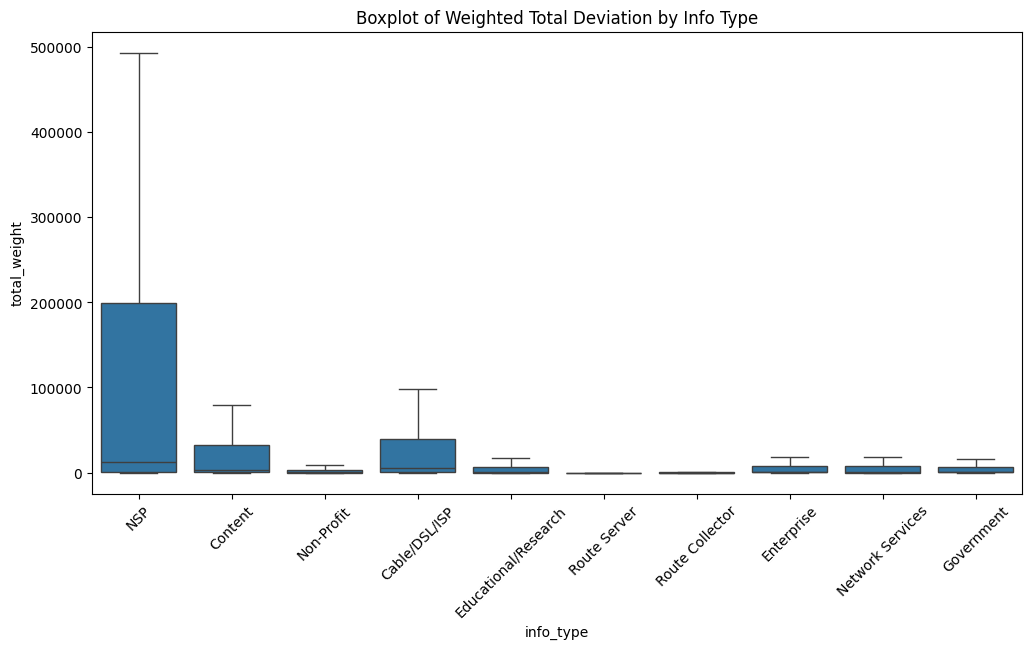

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter out rows where total_weight is NaN for cleaner plot
filtered_joined = joined.dropna(subset=['total_weight'])

# Create boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(data=filtered_joined, x='info_type', y='total_weight', showfliers=False)
plt.xticks(rotation=45)
plt.title('Boxplot of Weighted Total Deviation by Info Type')
plt.show()

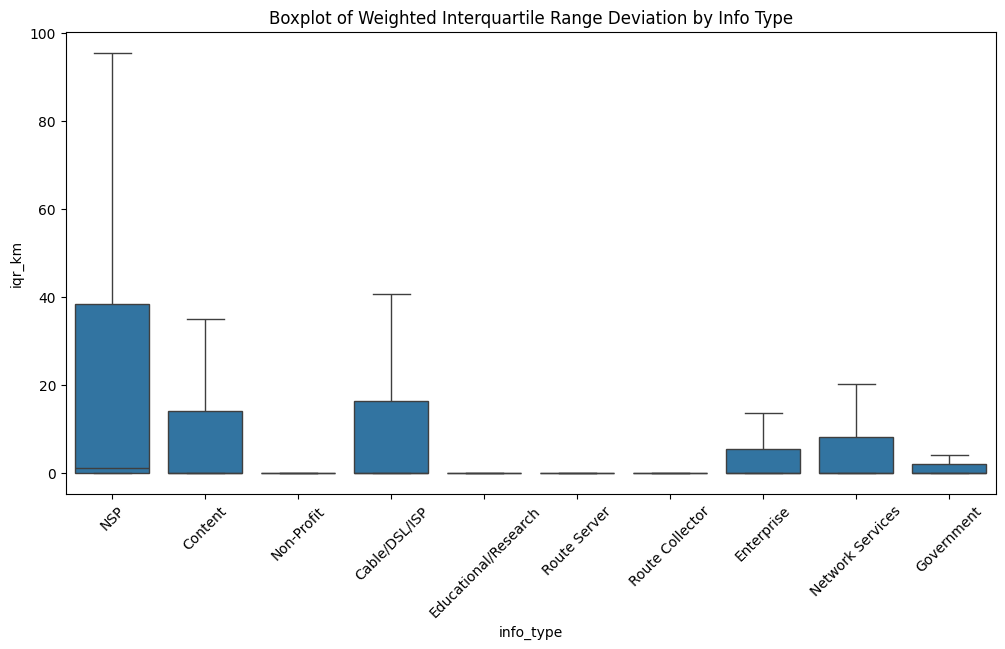

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter out rows where total_weight is NaN for cleaner plot
filtered_joined = joined.dropna(subset=['iqr_km'])

# Create boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(data=filtered_joined, x='info_type', y='iqr_km', showfliers=False)
plt.xticks(rotation=45)
plt.title('Boxplot of Weighted Interquartile Range Deviation by Info Type')
plt.show()

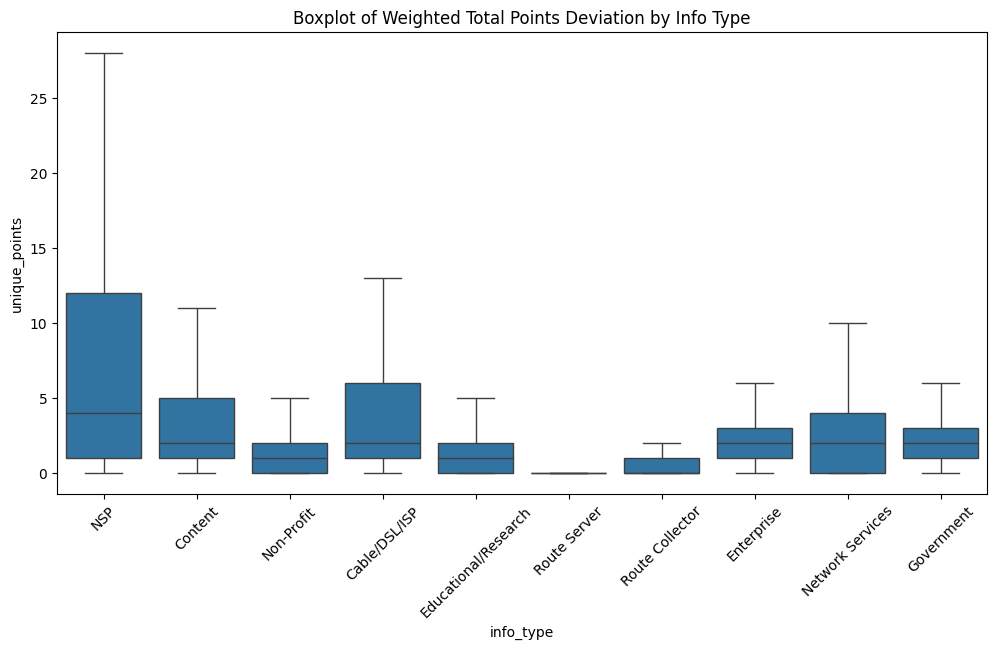

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter out rows where total_weight is NaN for cleaner plot
filtered_joined = joined.dropna(subset=['unique_points'])

# Create boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(data=filtered_joined, x='info_type', y='unique_points', showfliers=False)
plt.xticks(rotation=45)
plt.title('Boxplot of Weighted Total Points Deviation by Info Type')
plt.show()

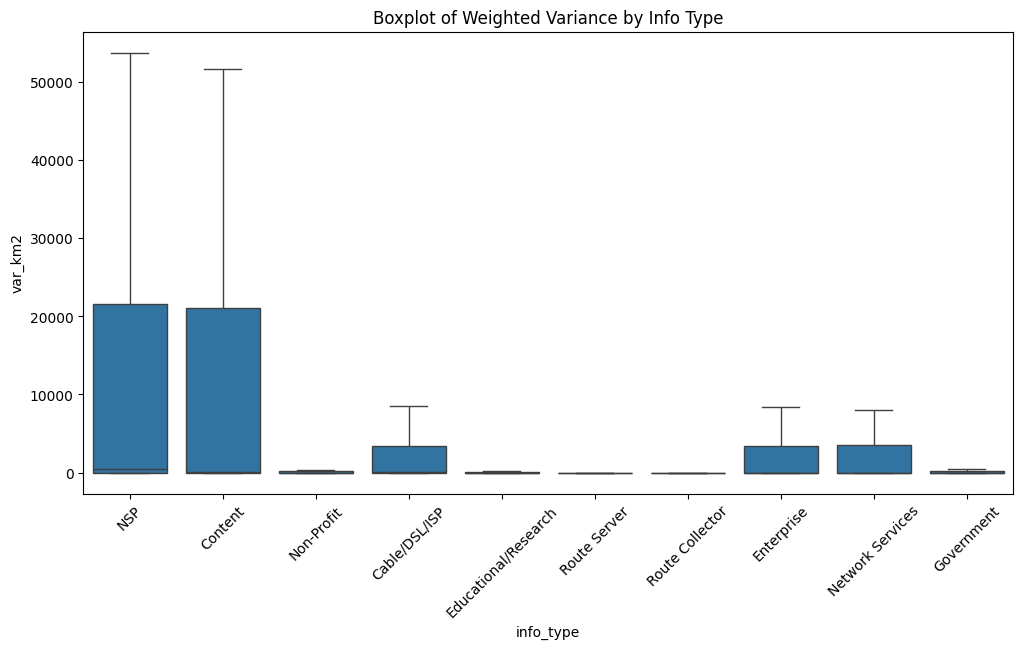

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter out rows where total_weight is NaN for cleaner plot
filtered_joined = joined.dropna(subset=['var_km2'])

# Create boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(data=filtered_joined, x='info_type', y='var_km2', showfliers=False)
plt.xticks(rotation=45)
plt.title('Boxplot of Weighted Variance by Info Type')
plt.show()

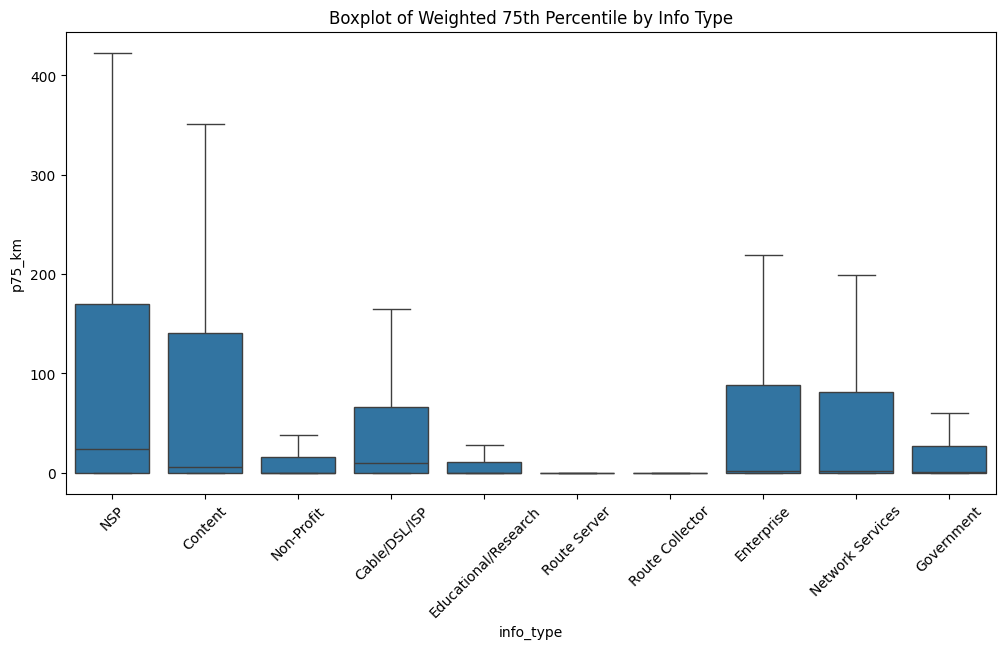

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter out rows where total_weight is NaN for cleaner plot
filtered_joined = joined.dropna(subset=['p75_km'])

# Create boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(data=filtered_joined, x='info_type', y='p75_km', showfliers=False)
plt.xticks(rotation=45)
plt.title('Boxplot of Weighted 75th Percentile by Info Type')
plt.show()

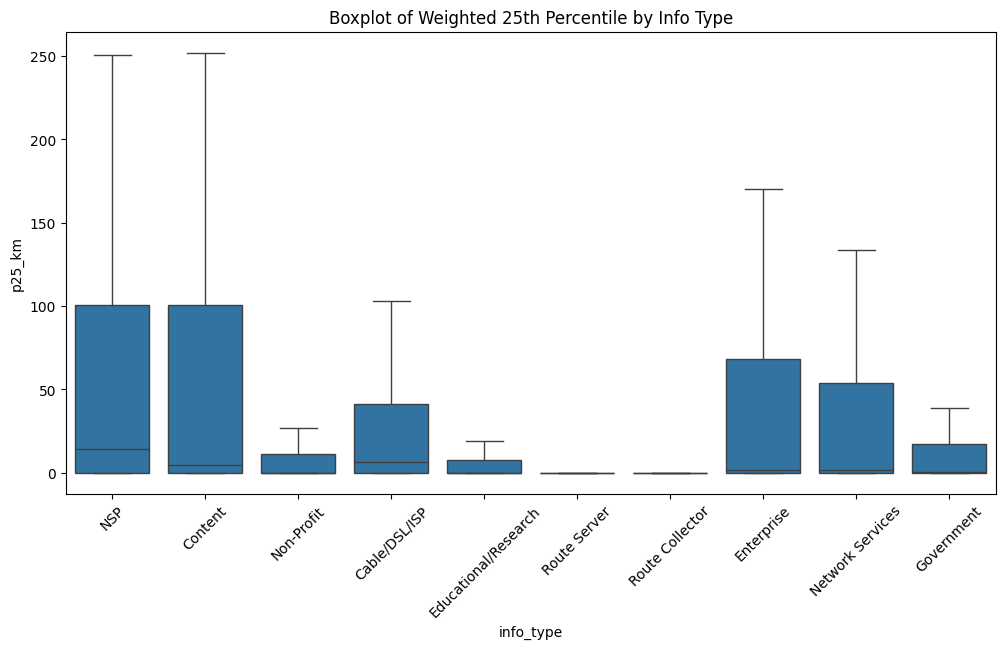

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter out rows where total_weight is NaN for cleaner plot
filtered_joined = joined.dropna(subset=['p25_km'])

# Create boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(data=filtered_joined, x='info_type', y='p25_km', showfliers=False)
plt.xticks(rotation=45)
plt.title('Boxplot of Weighted 25th Percentile by Info Type')
plt.show()

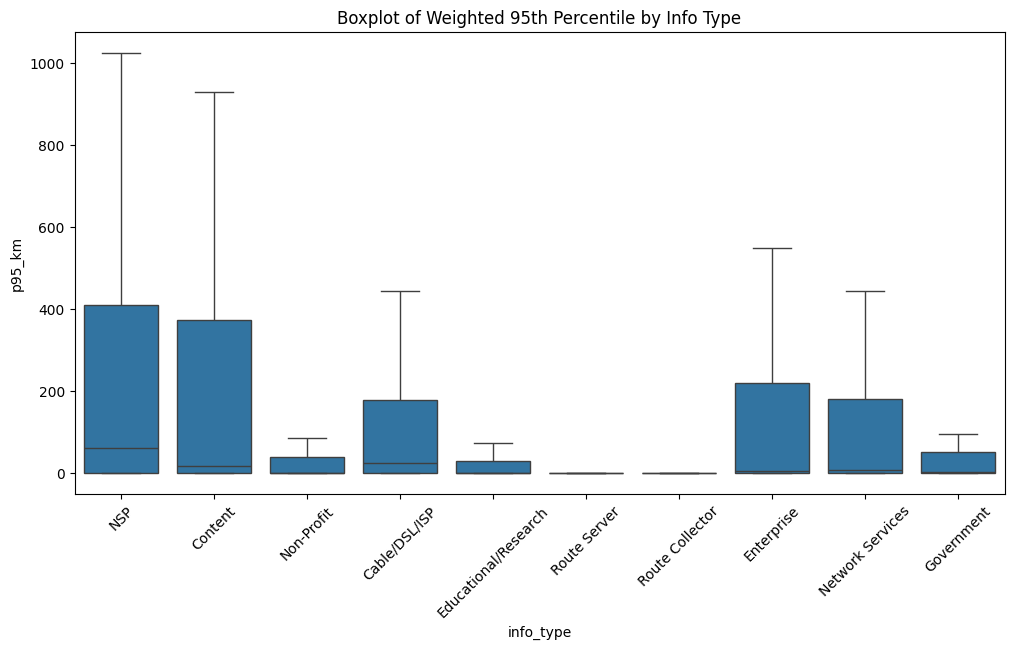

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter out rows where total_weight is NaN for cleaner plot
filtered_joined = joined.dropna(subset=['p95_km'])

# Create boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(data=filtered_joined, x='info_type', y='p95_km', showfliers=False)
plt.xticks(rotation=45)
plt.title('Boxplot of Weighted 95th Percentile by Info Type')
plt.show()

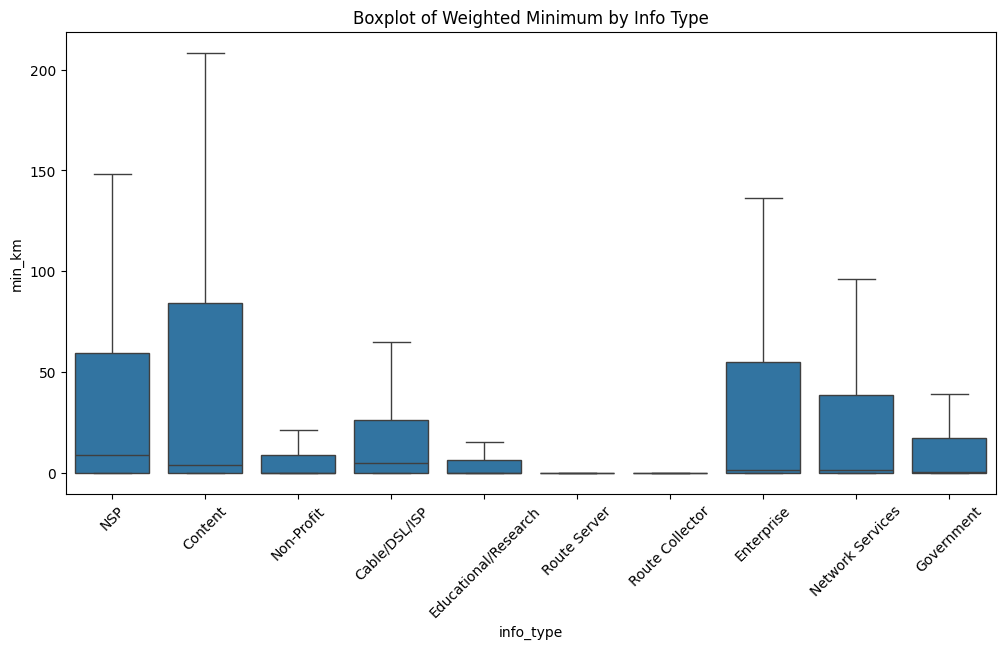

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter out rows where total_weight is NaN for cleaner plot
filtered_joined = joined.dropna(subset=['min_km'])

# Create boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(data=filtered_joined, x='info_type', y='min_km', showfliers=False)
plt.xticks(rotation=45)
plt.title('Boxplot of Weighted Minimum by Info Type')
plt.show()

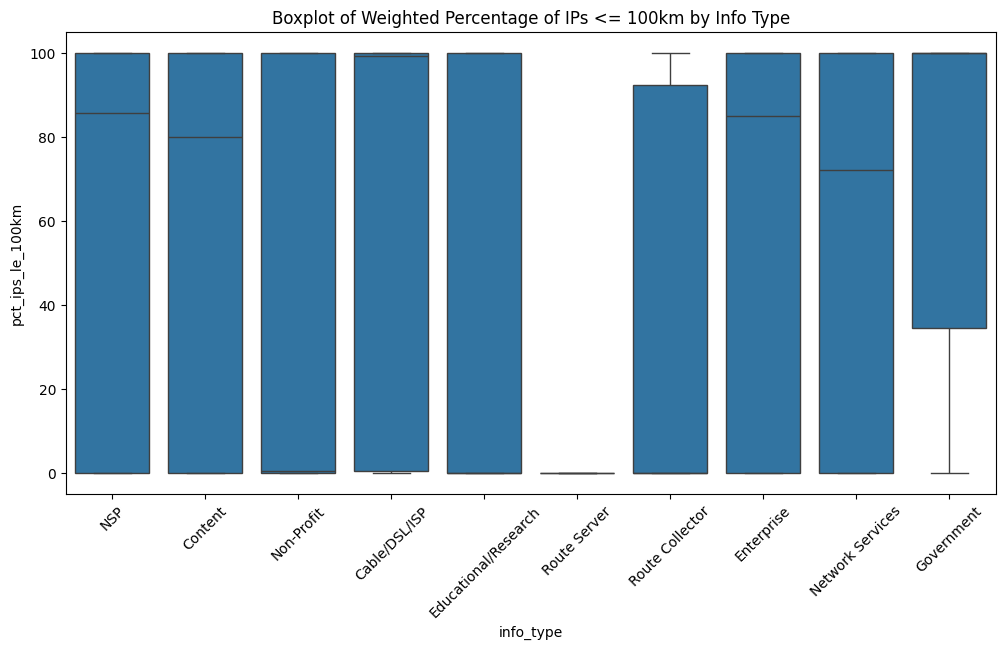

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter out rows where total_weight is NaN for cleaner plot
filtered_joined = joined.dropna(subset=['pct_ips_le_100km'])

# Create boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(data=filtered_joined, x='info_type', y='pct_ips_le_100km', showfliers=False)
plt.xticks(rotation=45)
plt.title('Boxplot of Weighted Percentage of IPs <= 100km by Info Type')
plt.show()

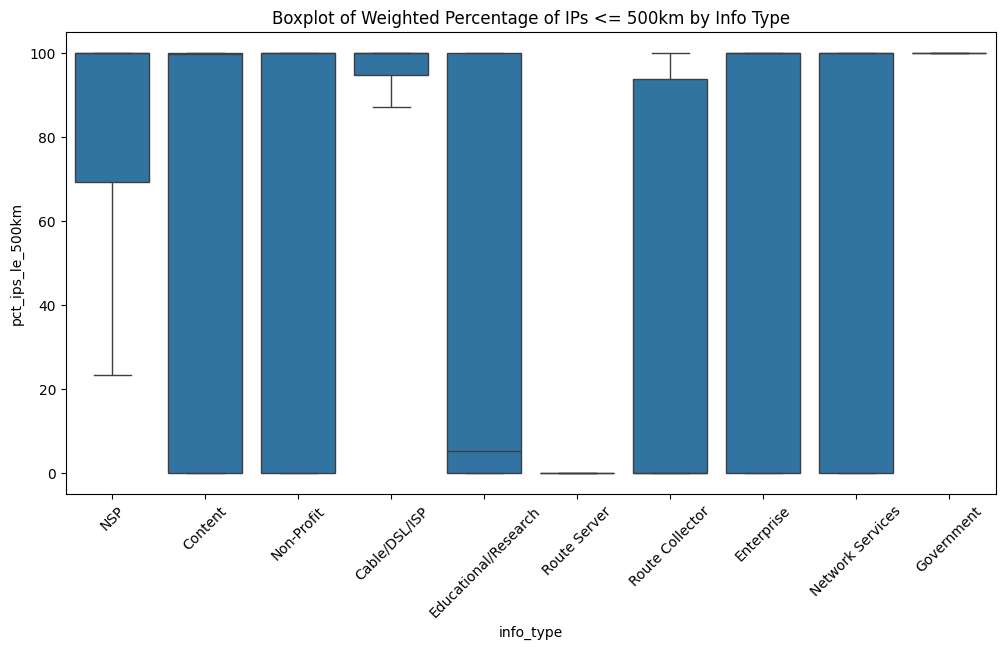

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter out rows where total_weight is NaN for cleaner plot
filtered_joined = joined.dropna(subset=['pct_ips_le_500km'])

# Create boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(data=filtered_joined, x='info_type', y='pct_ips_le_500km', showfliers=False)
plt.xticks(rotation=45)
plt.title('Boxplot of Weighted Percentage of IPs <= 500km by Info Type')
plt.show()

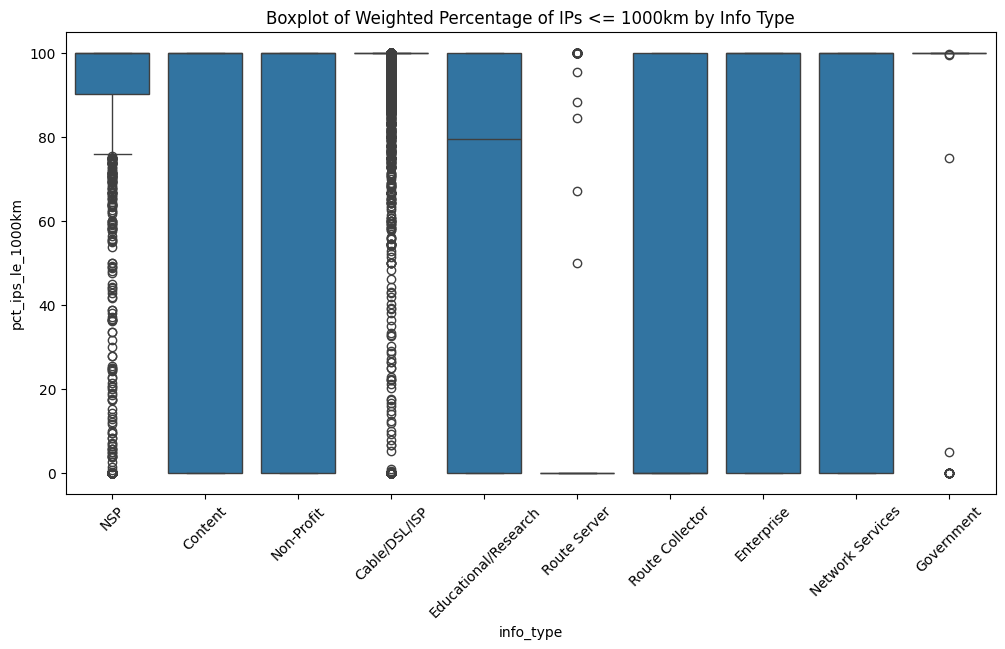

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter out rows where total_weight is NaN for cleaner plot
filtered_joined = joined.dropna(subset=['pct_ips_le_1000km'])

# Create boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(data=filtered_joined, x='info_type', y='pct_ips_le_1000km', showfliers=True)
plt.xticks(rotation=45)
plt.title('Boxplot of Weighted Percentage of IPs <= 1000km by Info Type')
plt.show()